# Explore Data: Session 7

Data Collected from Olin Students and Prospective Students

April 6, 2022

* Process json --> numpy
* Visualize trace
* PCA
* SVM

In [55]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import glob

import bisect
import random

from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

In [56]:
meta_data_path = "meta_session_7.tsv"
jsons_base_path = "raw_data_session_7"
FIG_SIZE = (10, 7)
random.seed(42)

## Load Meta Data

In [57]:
# load meta_data
meta_data = pd.read_csv(meta_data_path, sep="\t", header=2)
meta_data = meta_data[meta_data["Keep"] == "keep"]
meta_data = meta_data[["Username", "Intent"]]
meta_data = meta_data.reset_index()
meta_data["trial"] = meta_data.index
meta_data["firebase"] = meta_data.apply(lambda x: x["Username"] + str(x["Intent"]), axis=1)
meta_data

,index,Username,Intent,trial,firebase
0,2,achang,A,0,achangA
1,3,Andrew,B,1,AndrewB
2,4,kguerra,A,2,kguerraA
3,5,kguerra,B,3,kguerraB
4,6,Amyah,A,4,AmyahA
5,8,Nyah,A,5,NyahA
6,10,pogunbufunmi,A,6,pogunbufunmiA
7,11,pogunbufunmi,B,7,pogunbufunmiB
8,12,dgarcia,A,8,dgarciaA
9,13,dgarcia,B,9,dgarciaB


In [58]:
def parse_json(entry=0, visualize_trace=False):
    # read 1 json
    file_prefix = meta_data["firebase"][entry]
    file_name = f"{jsons_base_path}/{file_prefix}_*"
    print("open", file_name)
    with open(glob.glob(file_name)[0], "r") as f:
        j = json.loads(f.read())
        
    j_am = np.array(j["attitudes"]["measurements"])
    m_len = j_am.shape[0]
    t_len = len(j["attitudes"]["timestamps"])
    # sometimes 3 extra measurements with no corresponding timestamps
    if (m_len > t_len): 
        j_am = j_am[0:t_len]
    # sometimes vice versa
    if (m_len < t_len): 
        j_am = j_am[0:m_len]
    if (visualize_trace):
        print("j_am.shape", j_am.shape[0])
        print("j timestamps", len(j["attitudes"]["timestamps"]))
    
    j_lam = np.array(j["linearAccelerations"]["measurements"])
    m_len = j_lam.shape[0]
    t_len = len(j["linearAccelerations"]["timestamps"])
    # sometimes 3 extra measurements with no corresponding timestamps
    if (m_len > t_len): 
        j_lam = j_lam[0:t_len]
    # sometimes vice versa
    if (m_len < t_len): 
        j_lam = j_lam[0:m_len]
    
    if (visualize_trace):
        print("j_lam.shape", j_lam.shape[0])
        print("j timestamps", len(j["linearAccelerations"]["timestamps"]))
    

    p_a = pd.DataFrame(
        {"timestamps": j["attitudes"]["timestamps"],
         "a_1": j_am[:, 0],
         "a_2": j_am[:, 1],
         "a_3": j_am[:, 2],
         "a_4": j_am[:, 2]
        }
    )

    p_la = pd.DataFrame(
        {"timestamps": j["linearAccelerations"]["timestamps"],
         "la_x": j_lam[:, 0],
         "la_y": j_lam[:, 1],
         "la_z": j_lam[:, 2]
        }
    )
    
    p_gs = pd.DataFrame(
        {"timestamps": j["gestureStartEvents"]["timestamps"],
         "gs": [1] * len(j["gestureStartEvents"]["timestamps"])}
    )
    
    ##############################
    # IDENTIFY START OF GESTURES #
    ##############################
    
    # identify high variable regions
    p_la["la_x_m"] = p_la["la_x"].abs().rolling(1).max() # rolling 5
    p_la["la_y_m"] = p_la["la_y"].abs().rolling(1).max()
    p_la["la_z_m"] = p_la["la_z"].abs().rolling(1).max()    
    
    # if linear accelerations are above variance threshold
    # then gesture is happening
    #     if (meta_data["Intent"][entry] == 'C'):
    #         thresh_m = 0.03
    #     else:
    thresh_m = 0.4
    p_la["is_gesture"] = p_la.apply(lambda row:
        ((row["la_x_m"] > thresh_m) + 
        (row["la_y_m"] > thresh_m) + 
        (row["la_z_m"] > thresh_m) >= 1), axis=1)
    
    # get starting point of gesture segment
    ts = []
    last_ts = 0
    for index, row in p_la[p_la["is_gesture"].diff() == 1].iterrows():
        this_ts = row["timestamps"]
        if (this_ts - last_ts > 3): # if greater than 3 second, then new gesture
            ts.append(this_ts)
            last_ts = this_ts
    
    # based on visual observation, remove false starts at front and end of trial 
    #     print("ts:", len(ts))
    if (len(ts) > 12):
        ts = ts[-12:]
    print("starts:", len(ts))
    
    # if start starts before corresponding make gesture period, 
    # replace start with gs
    for i in range(len(ts)):
        gs_i = j["gestureStartEvents"]["timestamps"][i]
        ts_i = ts[i]
        if (ts_i < gs_i):
            ts[i] = gs_i
    
    p_start = pd.DataFrame(
        {"timestamps": ts,
         "start": [1] * len(ts)
        }
    )
    
    if (visualize_trace):
        fig, axs = plt.subplots(2, figsize=FIG_SIZE)
        fig.suptitle(f"Trial {entry}: {meta_data['firebase'][entry]} ({len(ts)})")
#         # plot attitudes
#         axs[0].plot(
#             p_a["timestamps"],
#             p_a["a_x"],
#         )
#         axs[0].plot(
#             p_a["timestamps"],
#             p_a["a_y"],
#         )
#         axs[0].plot(
#             p_a["timestamps"],
#             p_a["a_z"],
#         )
        axs[0].scatter(
            p_start["timestamps"],
            p_start["start"],
            c = "purple"
        )
        axs[0].scatter(
            p_gs["timestamps"],
            p_gs["gs"],
            c = "orange"
        )
        
        # plot linear acceleration
        axs[1].plot(
            p_la["timestamps"],
            p_la["la_x"],
        )
        axs[1].plot(
            p_la["timestamps"],
            p_la["la_y"],
        )
        axs[1].plot(
            p_la["timestamps"],
            p_la["la_z"],
        )
        axs[1].scatter(
            p_start["timestamps"],
            p_start["start"],
            c = "purple"
        )
        axs[1].scatter(
            p_gs["timestamps"],
            p_gs["gs"],
            c = "orange"
        )
            
    return p_a, p_la, p_start, j["gestureStartEvents"]["gestureNames"]

open raw_data_session_7/achangA_*
j_am.shape 6970
j timestamps 6970
j_lam.shape 6958
j timestamps 6958
starts: 12
open raw_data_session_7/AndrewB_*
j_am.shape 6868
j timestamps 6868
j_lam.shape 6841
j timestamps 6841
starts: 12
open raw_data_session_7/kguerraA_*
j_am.shape 6114
j timestamps 6114
j_lam.shape 5938
j timestamps 5938
starts: 12
open raw_data_session_7/kguerraB_*
j_am.shape 6706
j timestamps 6706
j_lam.shape 6599
j timestamps 6599
starts: 12
open raw_data_session_7/AmyahA_*
j_am.shape 6971
j timestamps 6971
j_lam.shape 6903
j timestamps 6903
starts: 12
open raw_data_session_7/NyahA_*
j_am.shape 6277
j timestamps 6277
j_lam.shape 6189
j timestamps 6189
starts: 12
open raw_data_session_7/pogunbufunmiA_*
j_am.shape 7176
j timestamps 7176
j_lam.shape 7109
j timestamps 7109
starts: 12
open raw_data_session_7/pogunbufunmiB_*
j_am.shape 7396
j timestamps 7396
j_lam.shape 7382
j timestamps 7382
starts: 12
open raw_data_session_7/dgarciaA_*
j_am.shape 4767
j timestamps 4767
j_lam.sh

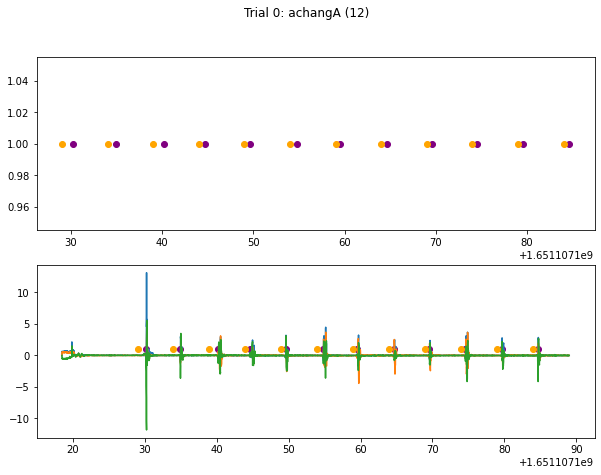

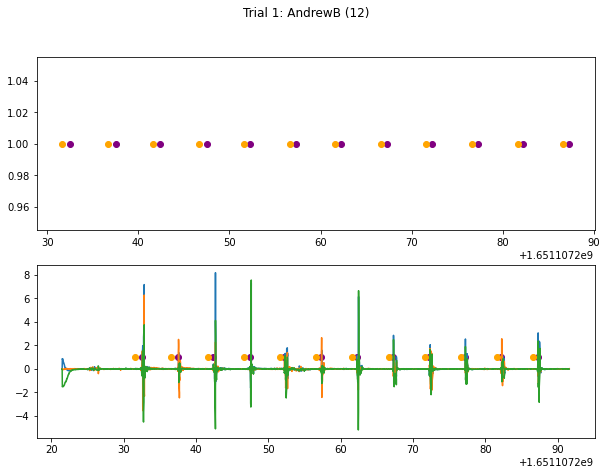

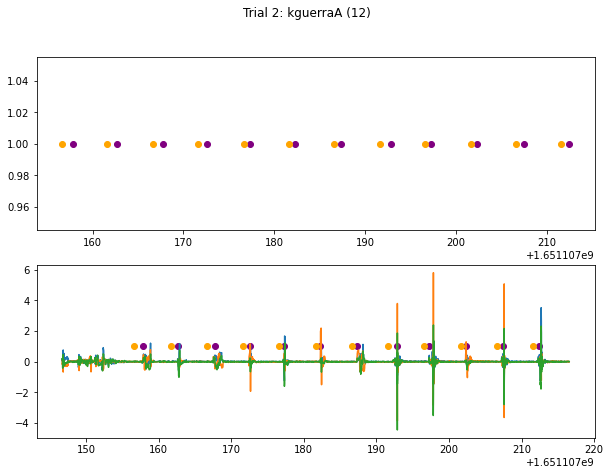

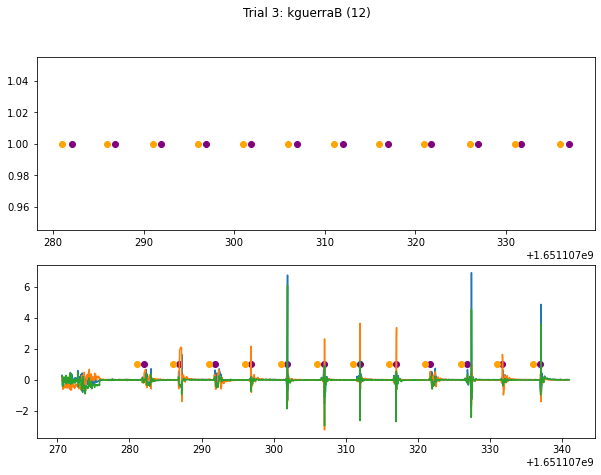

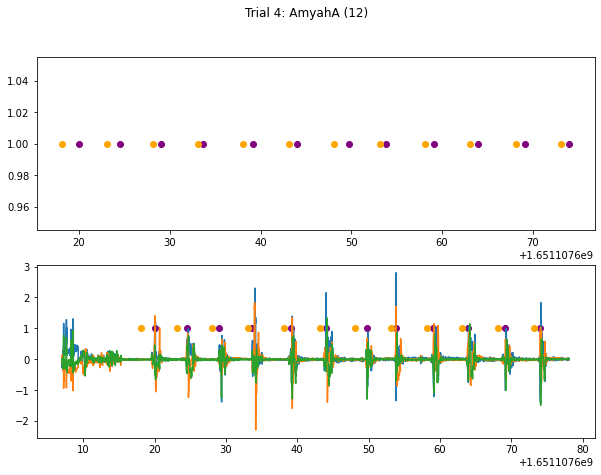

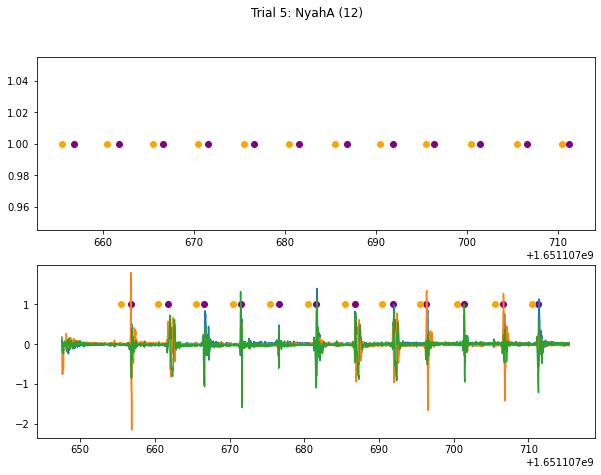

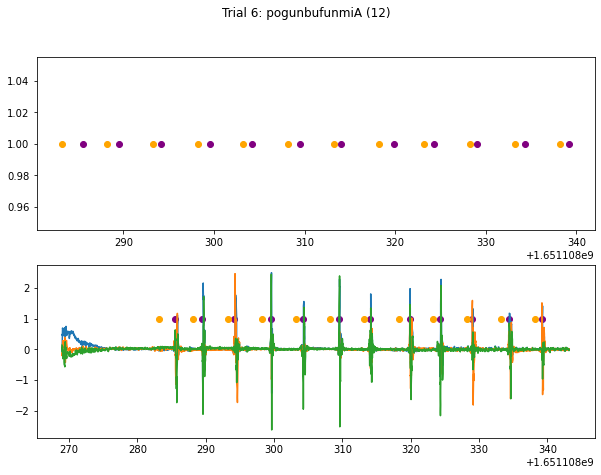

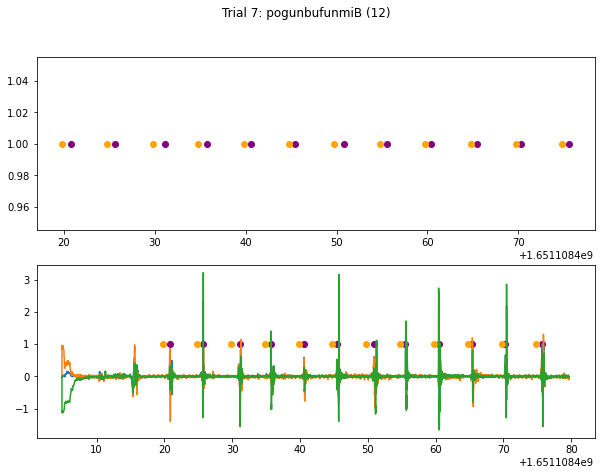

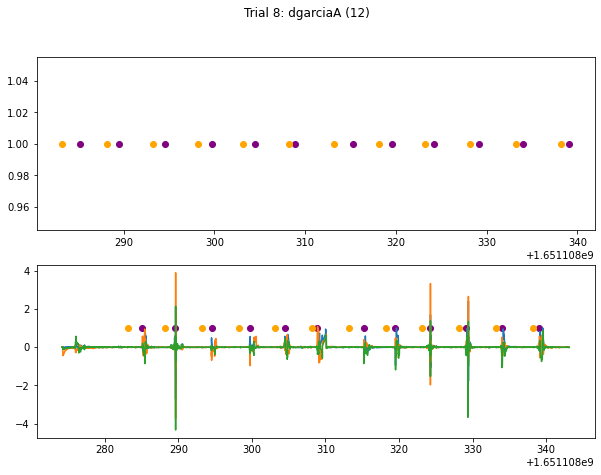

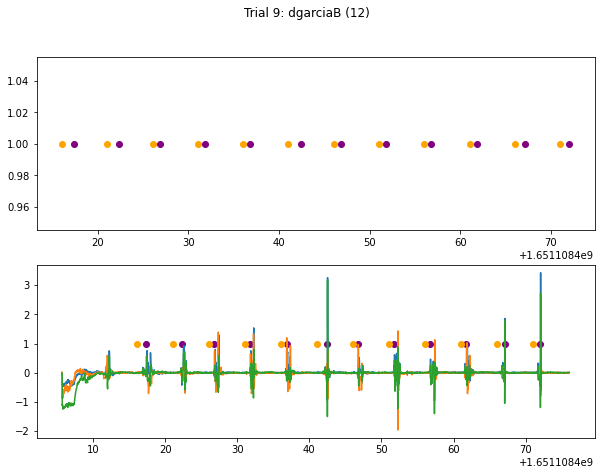

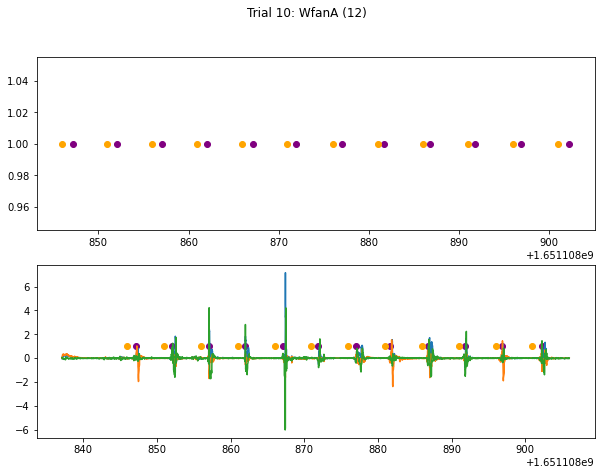

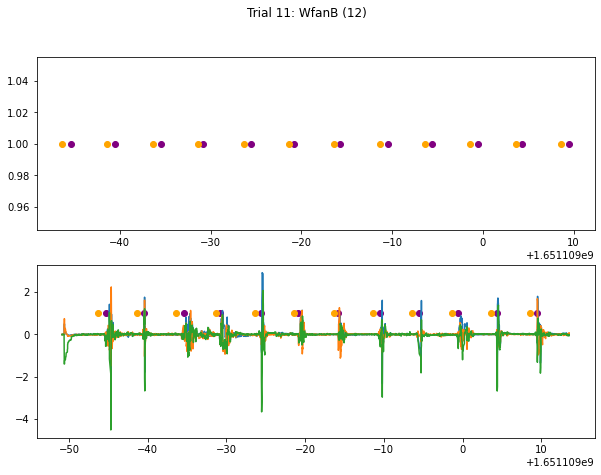

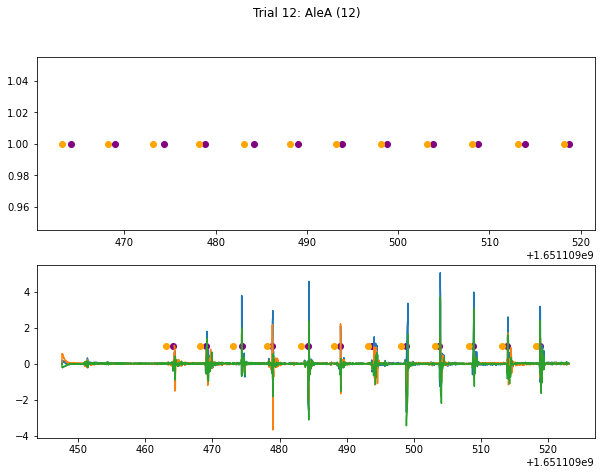

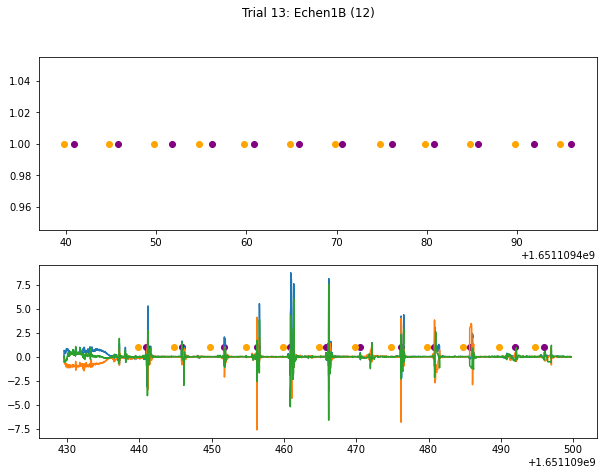

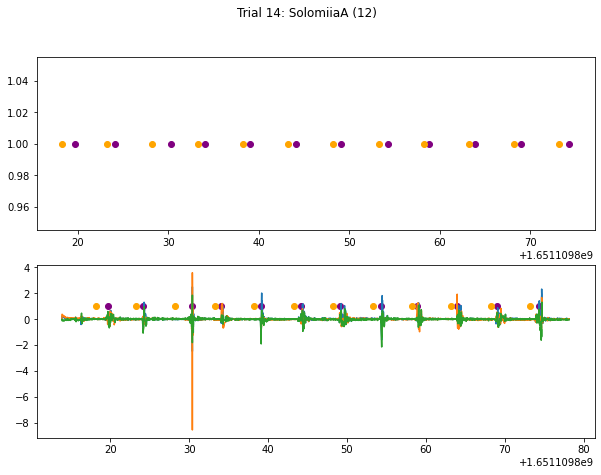

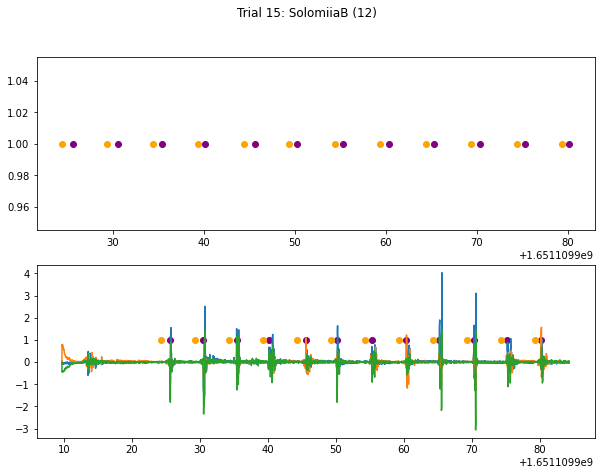

In [59]:
p_a_list = []
p_la_list = []
p_start_list = []
g_labels = []

for i in range(len(meta_data)):
    p_a, p_la, p_start, g_label = parse_json(i, visualize_trace=True)
    p_a_list.append(p_a)
    p_la_list.append(p_la)
    p_start_list.append(p_start)
    g_labels.append(g_label)

0.010971144066852324


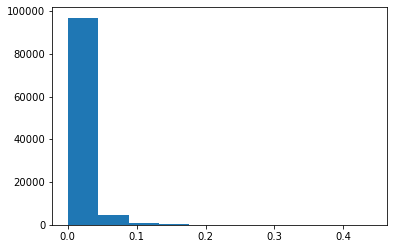

In [60]:
# figure out sampling rate
a_diffs = []
for p_a in p_a_list:
    for i in range(len(p_a["timestamps"]) - 1):
        a_diffs.append(p_a["timestamps"][i + 1] - p_a["timestamps"][i])

plt.hist(a_diffs)
print(np.mean(a_diffs))

0.01114772834399859


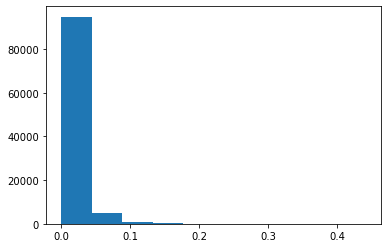

In [61]:
# figure out sampling rate
la_diffs = []
for p_la in p_la_list:
    for i in range(len(p_la["timestamps"]) - 1):
        la_diffs.append(p_la["timestamps"][i + 1] - p_la["timestamps"][i])

plt.hist(la_diffs)
print(np.mean(la_diffs))

In [62]:
1 / 0.01 # 1 seconds for each gesture

100.0

# Make metadata file for all gestures

In [63]:
len(g_labels)

16

In [64]:
g_labels

[['B', 'B', 'C', 'A', 'A', 'C', 'D', 'D', 'D', 'C', 'A', 'B'],
 ['C', 'D', 'B', 'B', 'C', 'D', 'B', 'A', 'C', 'A', 'D', 'A'],
 ['C', 'B', 'C', 'D', 'B', 'D', 'C', 'A', 'A', 'D', 'A', 'B'],
 ['C', 'D', 'C', 'D', 'B', 'A', 'A', 'A', 'C', 'B', 'D', 'B'],
 ['D', 'C', 'A', 'D', 'B', 'C', 'A', 'D', 'B', 'C', 'A', 'B'],
 ['D', 'C', 'B', 'A', 'A', 'B', 'C', 'C', 'D', 'A', 'D', 'B'],
 ['C', 'B', 'D', 'A', 'B', 'A', 'A', 'C', 'B', 'D', 'C', 'D'],
 ['D', 'B', 'C', 'A', 'D', 'B', 'C', 'A', 'A', 'D', 'B', 'C'],
 ['C', 'A', 'D', 'D', 'C', 'D', 'B', 'B', 'A', 'A', 'B', 'C'],
 ['C', 'A', 'C', 'C', 'D', 'B', 'D', 'A', 'A', 'D', 'B', 'B'],
 ['D', 'A', 'A', 'A', 'B', 'B', 'C', 'D', 'C', 'B', 'D', 'C'],
 ['A', 'A', 'C', 'C', 'B', 'D', 'D', 'A', 'B', 'C', 'B', 'D'],
 ['D', 'C', 'B', 'D', 'B', 'D', 'C', 'B', 'A', 'A', 'C', 'A'],
 ['B', 'A', 'D', 'A', 'B', 'B', 'C', 'A', 'D', 'D', 'C', 'C'],
 ['C', 'B', 'A', 'D', 'B', 'A', 'C', 'B', 'D', 'D', 'C', 'A'],
 ['B', 'B', 'A', 'C', 'D', 'B', 'C', 'D', 'A', 'A', 'C'

In [65]:
meta_data.shape

(16, 5)

In [66]:
meta_data["gestures"] = g_labels
meta_data_gestures = meta_data.explode("gestures")
meta_data_gestures["gesture_num"] = meta_data_gestures["gestures"].map({
    "A": 1, "B": 2, "C": 3, "D": 4})
meta_data_gestures["index"] = range(len(meta_data_gestures))
meta_data_gestures = meta_data_gestures.set_index("index")
meta_data_gestures

,Username,Intent,trial,firebase,gestures,gesture_num
index,,,,,,
0,achang,A,0,achangA,B,2
1,achang,A,0,achangA,B,2
2,achang,A,0,achangA,C,3
3,achang,A,0,achangA,A,1
4,achang,A,0,achangA,A,1
...,...,...,...,...,...,...
187,Solomiia,B,15,SolomiiaB,D,4
188,Solomiia,B,15,SolomiiaB,A,1
189,Solomiia,B,15,SolomiiaB,A,1


In [67]:
def extract_segment(p_a, p_la, p_start, tp=100, ofs=25):
    # create segements of gestures
    # 7 measurement channels
    # 100 time points (~1 seconds) (offset 100 from crossing max)
    res = np.zeros((len(p_start["timestamps"]),
                   7,
                   tp))
    
    for i in range((len(p_start["timestamps"]))):
        # get time start of tap
        start = p_start["timestamps"][i]
        
        # get index of first valid time in p_la
        p_la_i = bisect.bisect_left(list(p_la["timestamps"]), start)
        p_la_i -= ofs
        p_la_gesture = p_la.iloc[p_la_i:p_la_i+tp, :]
        res[i][0][:] = p_la_gesture["la_x"]
        res[i][1][:] = p_la_gesture["la_y"]
        res[i][2][:] = p_la_gesture["la_z"]
        
        # get index of first valid time in p_a
        p_a_i = bisect.bisect_left(list(p_a["timestamps"]), start)
        p_a_i -= ofs
        p_a_gesture = p_a.iloc[p_a_i:p_a_i+tp, :]
        res[i][3][:] = p_a_gesture["a_1"]
        res[i][4][:] = p_a_gesture["a_2"]
        res[i][5][:] = p_a_gesture["a_3"]
        res[i][6][:] = p_a_gesture["a_4"]
           
    return res

In [68]:
# create segemented data -- ignore walking trials (too messy)
res = []
for i in range(len(meta_data)): 
    p_a = p_a_list[i]
    p_la = p_la_list[i]
    p_start = p_start_list[i]
    res.append(extract_segment(p_a, p_la, p_start))
    data = np.concatenate(res, axis=0)

In [69]:
data.shape

(192, 7, 100)

# Save Gestures Data + Labels

In [70]:
meta_data_gestures

,Username,Intent,trial,firebase,gestures,gesture_num
index,,,,,,
0,achang,A,0,achangA,B,2
1,achang,A,0,achangA,B,2
2,achang,A,0,achangA,C,3
3,achang,A,0,achangA,A,1
4,achang,A,0,achangA,A,1
...,...,...,...,...,...,...
187,Solomiia,B,15,SolomiiaB,D,4
188,Solomiia,B,15,SolomiiaB,A,1
189,Solomiia,B,15,SolomiiaB,A,1


In [71]:
save_data = data.reshape((data.shape[0], -1))
save_data.shape

(192, 700)

In [72]:
meta_data_gestures.to_csv("meta_gestures.csv")

In [73]:
np.savetxt("data_gestures.csv", save_data)

## Create Train Test Split

Total trials: 25
    
    * session 4 train-test-split: 90:10  
    * test: test 3 (x12 = 36)
        * trials: [2, 6, 11] (randomly chosen)
    * train: train 22 (x12 = 264)

In [74]:
def get_train_test_split(test_trials=[1, 4, 5]):
    """
    Split train and test but keep gestures from the same trial in the same dataset 
    """
    # subset test
    test_labels = meta_data_gestures[meta_data_gestures["trial"].isin(test_trials)][["trial", "gesture_num"]]

    # rest are train
    train_labels = meta_data_gestures[~meta_data_gestures["trial"].isin(test_trials)][["trial", "gesture_num"]]

    test_data = data[test_labels.index]
    test_labels["index"] = range(0, len(test_labels))
    test_labels = test_labels.set_index("index")

    train_data = data[train_labels.index]
    train_labels["index"] = range(0, len(train_labels))
    train_labels = train_labels.set_index("index")
    
    return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = get_train_test_split(test_trials=[2, 6, 11])

In [75]:
test_data.shape

(36, 7, 100)

In [76]:
train_data.shape

(156, 7, 100)

## Visualize Train Traces

In [77]:
train_labels

,trial,gesture_num
index,,
0,0,2
1,0,2
2,0,3
3,0,1
4,0,1
...,...,...
151,15,4
152,15,1
153,15,1


In [78]:
train_labels["trial"].unique()

array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 15])

In [79]:
def plot_trace(t_data, t_labels, choose_gesture = 1, choose_channel = 1):
    gestures = t_data[t_labels[t_labels["gesture_num"] == choose_gesture].index]
    print(gestures.shape)

    fig = plt.figure()
    ax = plt.axes()
    for i in range(gestures.shape[0]):
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])

(39, 7, 100)
(39, 7, 100)
(39, 7, 100)
(39, 7, 100)


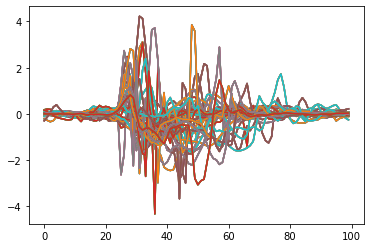

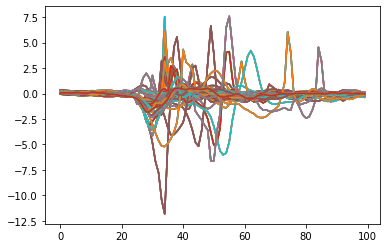

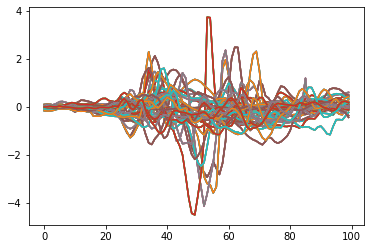

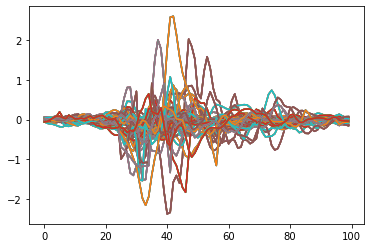

In [80]:
# train data for gesture
plot_trace(train_data, train_labels, choose_gesture = 1, choose_channel = 2)
plot_trace(train_data, train_labels, choose_gesture = 2, choose_channel = 2)
plot_trace(train_data, train_labels, choose_gesture = 3, choose_channel = 2)
plot_trace(train_data, train_labels, choose_gesture = 4, choose_channel = 2)

**normalize quaternian relative to start quaternain**

In [106]:
# # normalize quaternian relative to start
# train_data.shape

In [89]:
# from pyquaternion import Quaternion

In [90]:
# Quaternion(0.09394614, -0.19572926, 0.18491943, 0.18491943)

Quaternion(0.09394614, -0.19572926, 0.18491943, 0.18491943)

In [98]:
# def normalize_quaternians(data):
#     # q1: orientation at start of window
#     # q2: orientation at time point (0-99)
#     # q_diff * q1 = q2
#     # remember that quaternians use left-handed multiplication
#     # q_diff = q2 * inv(q1)
#     # since the quaternians are all rotation quaternians, they should be rotation quaternians
#     # so the inverse is just the conjugate (i.e. negate i, j, and k components)
#     norm_data = np.copy(data)
#     for g in range(data.shape[0]):
#         q1 = data[g, 3:, 0]
#         for i in range(100):
#             q2 = data[g, 3:, i]
#             if (q1[0] == q2[0] and q1[1] == q2[1] and q1[2] == q2[2] and q1[3] == q2[3]):
#                 # no rotation
#                 norm_data[g, 3, i] = 0
#                 norm_data[g, 4, i] = 0
#                 norm_data[g, 5, i] = 0
#                 norm_data[g, 6, i] = 0
#             else:
#                 inv_q1 = q1
#                 inv_q1[0] = -q1[0] # w
#                 inv_q1[1] = -q1[1] # x
#                 inv_q1[2] = -q1[2] # y
#                 inv_q1[3] = q1[3] # z
#                 qq2 = Quaternion(q2[0], q2[1], q2[2], q2[3])
#                 qinvq1 = Quaternion(inv_q1[0], inv_q1[1], inv_q1[2], inv_q1[3])
#                 qdiff = qq2 * qinvq1
                
#                 norm_data[g, 3, i] = qdiff[0]
#                 norm_data[g, 4, i] = qdiff[1]
#                 norm_data[g, 5, i] = qdiff[2]
#                 norm_data[g, 6, i] = qdiff[3]
                
#     return norm_data

In [107]:
# norm_train_data = normalize_quaternians(train_data)
# norm_train_data.shape

In [108]:
# print(train_data[0, 3:, 0])
# print(train_data[0, 3:, 1])
# print(train_data[0, 3:, 2])

In [109]:
# print(norm_train_data[0, 3:, 0])
# print(norm_train_data[0, 3:, 1])
# print(norm_train_data[0, 3:, 2])

In [110]:
# # train data for gesture
# plot_trace(train_data, train_labels, choose_gesture = 1, choose_channel = 3)
# plot_trace(train_data, train_labels, choose_gesture = 2, choose_channel = 3)
# plot_trace(train_data, train_labels, choose_gesture = 3, choose_channel = 3)
# plot_trace(train_data, train_labels, choose_gesture = 4, choose_channel = 3)

In [105]:
# # train data for gesture
# plot_trace(norm_train_data, train_labels, choose_gesture = 1, choose_channel = 3)
# plot_trace(norm_train_data, train_labels, choose_gesture = 2, choose_channel = 3)
# plot_trace(norm_train_data, train_labels, choose_gesture = 3, choose_channel = 3)
# plot_trace(norm_train_data, train_labels, choose_gesture = 4, choose_channel = 3)

In [ ]:
# # train data for gesture
# plot_trace(train_data, train_labels, choose_gesture = 1, choose_channel = 2)
# plot_trace(train_data, train_labels, choose_gesture = 2, choose_channel = 2)
# plot_trace(train_data, train_labels, choose_gesture = 3, choose_channel = 2)
# plot_trace(train_data, train_labels, choose_gesture = 4, choose_channel = 2)

# Apply PCA and SVM

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
def run_pipeline(x_train, x_test, y_train, y_test, n_comp=0, 
                 show_confusion=True, show_pca_gesture=True, show_pca_trial=True):
    # Fit to data and predict gesture
    if n_comp == 0:
        n_pc = min(x_train.shape[0], x_train.shape[1])
    else:
        n_pc = n_comp
    clf = make_pipeline(StandardScaler(), PCA(n_components=n_pc), SVC())
    clf.fit(x_train, y_train["gesture_num"])
    pred_test = clf.predict(x_test)
    acc = accuracy_score(y_test["gesture_num"], pred_test)
    
    if (show_confusion):
        # print accuracy
        print("Prediction accuracy for test dataset")
        print(f"{acc:.2%}")

        # visualize confusion matrirx
        cm = confusion_matrix(y_test["gesture_num"], pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot()
        plt.show()

        # visualize pca
        scaler = clf.named_steps["standardscaler"]
        x_train_proj = scaler.transform(x_train)
        pca = clf.named_steps["pca"]
        x_train_proj = pca.transform(x_train_proj)

    if (show_pca_gesture):
        # plot train gesture
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        scatter = ax.scatter(
                x=x_train_proj[:, 0],
                y=x_train_proj[:, 1],
                c=y_train["gesture_num"],
                cmap="tab20",
            )
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(prop="colors"),
                            loc="lower left", title="Gestures")
        ax.add_artist(legend)

    if (show_pca_trial):
        # plot train trial
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        scatter = ax.scatter(
                x=x_train_proj[:, 0],
                y=x_train_proj[:, 1],
                c=y_train["trial"],
                cmap="tab20c",
            )
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(prop="colors"),
                            loc="lower left", title="Trials")
        ax.add_artist(legend)
        print("train trials", y_train["trial"].unique())
        
    return acc

(156, 700)
(36, 700)
Prediction accuracy for test dataset
72.22%


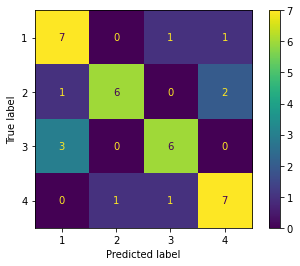

train trials [ 0  1  3  4  5  7  8  9 10 12 13 14 15]


0.7222222222222222

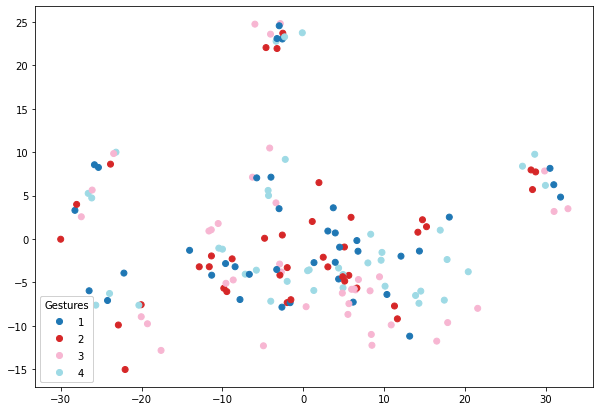

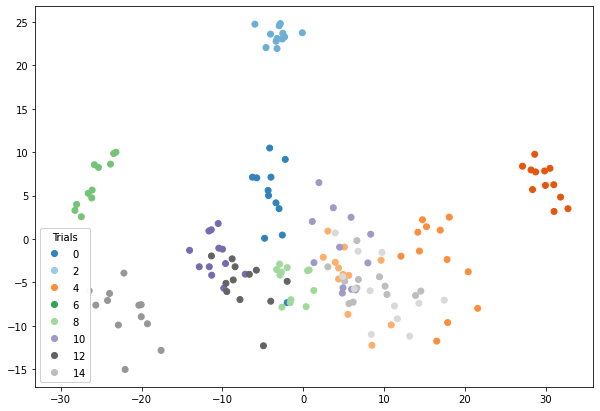

In [29]:
# reshape data to be gestures x ?
# max accuracy --> 77%
x_train = train_data.reshape(train_data.shape[0], -1)
print(x_train.shape)

x_test = test_data.reshape(test_data.shape[0], -1)
print(x_test.shape)

run_pipeline(x_train, x_test, train_labels, test_labels, n_comp=70)

(156, 300)
(36, 300)
Prediction accuracy for test dataset
77.78%


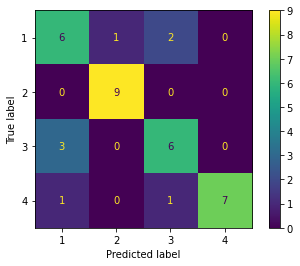

train trials [ 0  1  3  4  5  7  8  9 10 12 13 14 15]


0.7777777777777778

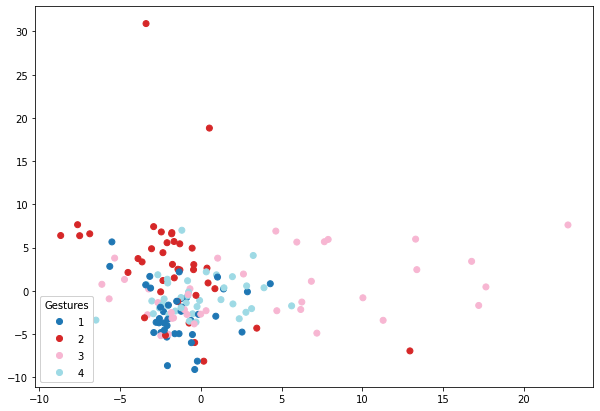

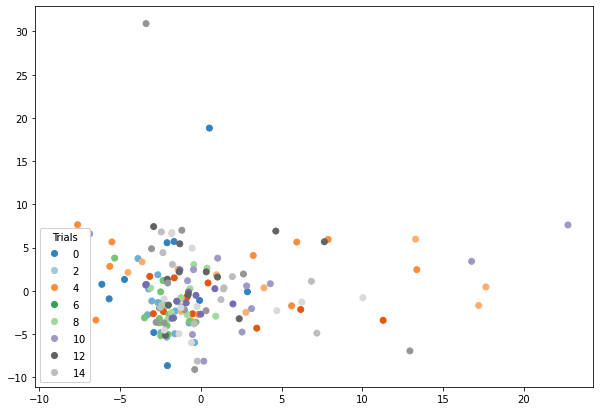

In [30]:
# reshape data to be gestures x ?, only use linear acceleration
# max accuracy --> 77%
x_train = train_data[:, 0:3, :].reshape(train_data.shape[0], -1)
print(x_train.shape)

x_test = test_data[:, 0:3, :].reshape(test_data.shape[0], -1)
print(x_test.shape)

run_pipeline(x_train, x_test, train_labels, test_labels, n_comp=70)

## BUG: color scheme is strange for trials-colored PCA plot

## Cross Validate Chosen Feature Set
* A set of 4 gestures was chosen because they appeared most commonly in the good feature set (distinguishable in test set at 83% with PCA + SVD) and themselves created a good feature set
    * 2 (swipe right)
    * 4 (swipe down)
    * 6 (counter bottom)
    * 9 (tap)
* The test set was comprised of 3 representative trials (12 gestures instances total):
    * 1 (45 deg, in air, chest-level)
    * 4 (0 deg, in air, thigh-level)
    * 5 (0 deg, on surface, thigh-level)
* Train set was comprised of remaining 6 trials (24 gesture instances total)

*With Cross Validation*: check if [2, 4, 6, 9] feature set is robustly good across other test trials

In [31]:
import itertools

In [32]:
def run_pipeline_on_gesture_list(train_data, train_labels, test_data, test_labels,
                                 gesture_list = [1, 2, 3, 4],
                                 show_confusion=False, show_pca_gesture=False, show_pca_trial=False):
    # choose gestures
    train_labels_chosen_gestures = train_labels[train_labels["gesture_num"].isin(gesture_list)]
    train_data_chosen_gestures = train_data[train_labels_chosen_gestures.index]
    train_labels_chosen_gestures

    test_labels_chosen_gestures = test_labels[test_labels["gesture_num"].isin(gesture_list)]
    test_data_chosen_gestures = test_data[test_labels_chosen_gestures.index]
    test_labels_chosen_gestures

    # reshape data to be gestures x ?
    # max accuracy --> 50%
    x_train = train_data_chosen_gestures[:, 0:3, :].reshape(train_data_chosen_gestures.shape[0], -1)
    print(x_train.shape)

    x_test = test_data_chosen_gestures[:, 0:3, :].reshape(test_data_chosen_gestures.shape[0], -1)
    print(x_test.shape)

    acc = run_pipeline(x_train, x_test, train_labels_chosen_gestures, test_labels_chosen_gestures, 
                       show_confusion=show_confusion, show_pca_gesture=show_pca_gesture, show_pca_trial=show_pca_trial)
    return acc

(156, 300)
(36, 300)
Prediction accuracy for test dataset
77.78%


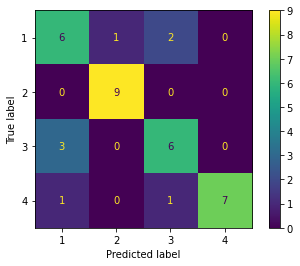

train trials [ 0  1  3  4  5  7  8  9 10 12 13 14 15]


0.7777777777777778

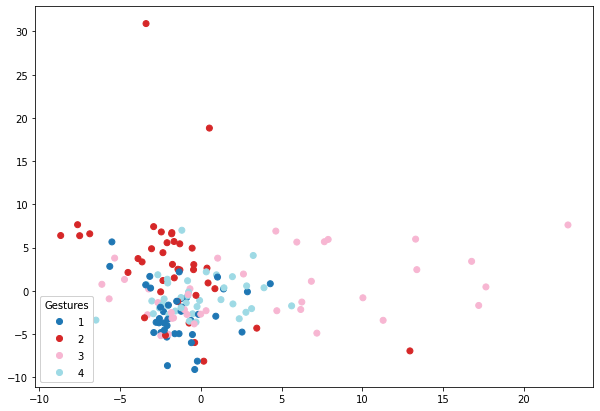

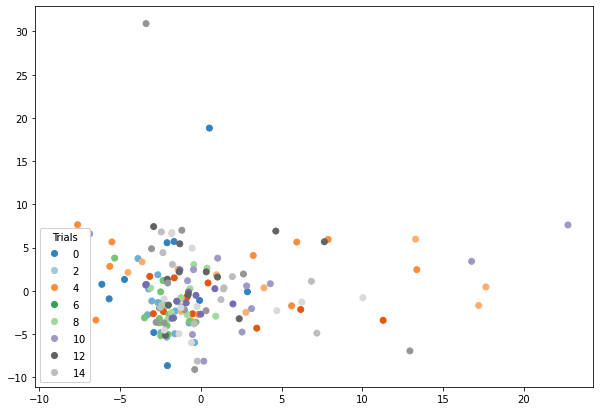

In [33]:
run_pipeline_on_gesture_list(train_data, train_labels, test_data, test_labels, 
                             gesture_list = [1, 2, 3, 4],
                             show_confusion=True, show_pca_gesture=True, show_pca_trial=True)

In [34]:
gesture_list = [2, 4, 6, 9]
comb_test_trials = list(itertools.combinations(range(0, 15), 3))
cross_val_acc = []
for ta, tb, tc in comb_test_trials:
    train_data, train_labels, test_data, test_labels = get_train_test_split(test_trials=[ta, tb, tc])
    print(train_data.shape, test_data.shape)
    print(len(train_labels), len(test_labels))
    acc = run_pipeline_on_gesture_list(train_data, train_labels, test_data, test_labels,
                                      gesture_list=gesture_list)
    cross_val_acc.append(acc)
    
df_cross_val = pd.DataFrame({
    "a": [a for a, b, c in comb_test_trials],
    "b": [b for a, b, c in comb_test_trials],
    "c": [c for a, b, c in comb_test_trials],
    "aIntent": [meta_data["Intent"][a] for a, b, c in comb_test_trials],
    "bIntent": [meta_data["Intent"][b] for a, b, c in comb_test_trials],
    "cIntent": [meta_data["Intent"][c] for a, b, c in comb_test_trials],
    "cross_val_acc": cross_val_acc 
})

(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
1

(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
1

(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7, 100) (36, 7, 100)
156 36
(78, 300)
(18, 300)
(156, 7,

In [35]:
df_cross_val = df_cross_val.sort_values("cross_val_acc")
df_cross_val

,a,b,c,aIntent,bIntent,cIntent,cross_val_acc
414,7,11,12,B,B,A,0.666667
325,4,10,11,A,A,B,0.666667
410,7,10,11,B,A,B,0.722222
29,0,3,8,A,B,A,0.722222
85,0,11,12,A,B,A,0.722222
...,...,...,...,...,...,...,...
168,1,13,14,B,B,A,1.000000
388,6,9,14,A,B,A,1.000000
387,6,9,13,A,B,B,1.000000
337,5,6,9,A,A,B,1.000000


100.0 of cross-val combs have greater than 50% acc


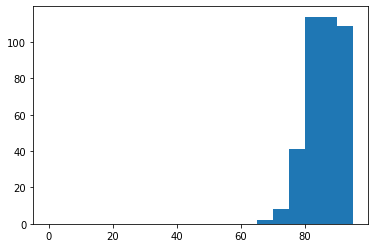

In [36]:
df_cross_val["cross_val_acc_percent"] = df_cross_val['cross_val_acc'].apply(lambda x: x * 100)
plt.hist(df_cross_val["cross_val_acc_percent"], bins=range(0, 100, 5))
print(100 * df_cross_val[df_cross_val["cross_val_acc"] > .5].shape[0] / df_cross_val.shape[0], "of cross-val combs have greater than 50% acc")

In [37]:
df_cross_val[df_cross_val["cross_val_acc"] > .5].shape

(455, 8)

In [38]:
df_cross_val[df_cross_val["cross_val_acc"] > .8].shape

(404, 8)

In [39]:
df_cross_val[df_cross_val["cross_val_acc"] > .9].shape

(176, 8)

In [40]:
df_cross_val.head(50)

,a,b,c,aIntent,bIntent,cIntent,cross_val_acc,cross_val_acc_percent
414,7,11,12,B,B,A,0.666667,66.666667
325,4,10,11,A,A,B,0.666667,66.666667
410,7,10,11,B,A,B,0.722222,72.222222
29,0,3,8,A,B,A,0.722222,72.222222
85,0,11,12,A,B,A,0.722222,72.222222
310,4,7,11,A,B,B,0.722222,72.222222
329,4,11,12,A,B,A,0.722222,72.222222
95,1,2,7,B,A,B,0.722222,72.222222
316,4,8,11,A,A,B,0.722222,72.222222
66,0,7,11,A,B,B,0.722222,72.222222


In [41]:
df_cross_val.tail(50)

,a,b,c,aIntent,bIntent,cIntent,cross_val_acc,cross_val_acc_percent
282,3,10,13,B,A,B,1.0,100.0
24,0,2,14,A,A,A,1.0,100.0
23,0,2,13,A,A,B,1.0,100.0
20,0,2,10,A,A,A,1.0,100.0
437,9,10,13,B,A,B,1.0,100.0
283,3,10,14,B,A,A,1.0,100.0
438,9,10,14,B,A,A,1.0,100.0
289,3,13,14,B,B,A,1.0,100.0
444,9,13,14,B,B,A,1.0,100.0
198,2,5,14,A,A,A,1.0,100.0


# Run and Save Final Session 7 Model

In [76]:
import joblib

In [93]:
def save_final_pipeline(x, y, n_comp=0, show_pca_gesture=True, save_as=""):
    # Fit to data, don't predict gesture (no test)
    if n_comp == 0:
        n_pc = min(x.shape[0], y.shape[1])
    else:
        n_pc = n_comp
    clf = make_pipeline(StandardScaler(), PCA(n_components=n_pc), SVC())
    clf.fit(x, y["gesture_num"])
    
    if (save_as != ""):
        joblib.dump(clf, save_as)
        print(f"Saved model to {save_as}")

    if (show_pca_gesture):
        # visualize pca
        scaler = clf.named_steps["standardscaler"]
        x_proj = scaler.transform(x)
        pca = clf.named_steps["pca"]
        x_proj = pca.transform(x_proj)
        
        # plot train gesture
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        scatter = ax.scatter(
                x=x_proj[:, 0],
                y=x_proj[:, 1],
                c=y["gesture_num"],
                cmap="tab20",
            )
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(prop="colors"),
                            loc="lower left", title="Gestures")
        ax.add_artist(legend)

In [94]:
print(x_train.shape)
print(x_test.shape)

x = np.vstack([x_train, x_test])
print(x.shape)

(156, 300)
(36, 300)
(192, 300)


In [95]:
y = pd.concat([train_labels, test_labels])
y

,trial,gesture_num
index,,
0,0,2
1,0,2
2,0,3
3,0,1
4,0,1
...,...,...
31,14,2
32,14,4
33,14,4


Saved model to pca_svm_full_model_session_7.pkl


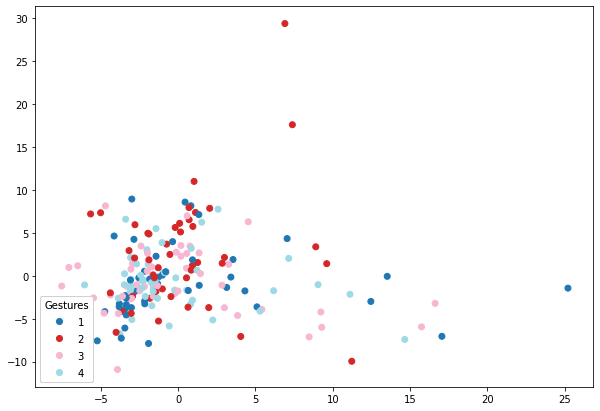

In [97]:
# reshape data to be gestures x ?
# accuracy --> 0.7549019607843137%
save_final_pipeline(x, y, save_as="pca_svm_full_model_session_7.pkl")